In [1]:
import psycopg2
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from create_staging_tables import create_loyalty_scores_df_STEP_EIGHT

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
engine = create_engine('postgresql://localhost:5432/wa_leg_staging')

In [3]:
merged_final_df = pd.read_sql_query('select * from "merged_final"',con=engine)
bill_text_df = pd.read_sql_query('select * from "bill_text"',con=engine)
rep_score_df = pd.read_sql_query('select * from "rep_score"',con=engine)

In [197]:
def create_clean_X(merged_final_df, bill_text_df, rep_score_df):
    
    # Add bill_text
    clean = merged_final_df.merge(bill_text_df, how='left', on=['unique_id', 'htm_url'])
    clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    clean.rename(columns={'sponsor_party': 'primary_sponsor_party'}, inplace=True)

    
    # Add rep_score and replace -1 values, then make dem_score
    clean['bill_num'] = clean['bill_id'].apply(lambda x: x.split()[1])
    clean['bill_num_unique'] = clean['biennium'] + ' ' + clean['bill_num']
    clean = clean.merge(rep_score_df, how='left', on='bill_num_unique')

    def replace_with_p_sponsor_party(row):
        primary_sponsor_party = row['primary_sponsor_party']
        if row['rep_score'] == -1:
            return primary_sponsor_party
        else:
            return row['rep_score']
    clean['rep_score'] = clean.apply(replace_with_p_sponsor_party, axis=1)
    clean['dem_score'] = 1 - clean['rep_score']
    
    
    # Add loyalty scores
#     clean = clean.merge(loyalty_df, how = 'left', on='voter_id')
#     clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    
    
    # Feature Engineering functions
    def create_congress_nums(biennium):
        '''Numbers bienniums so that 1991 is 1 and 1993 is 3.'''
        first_year = int((biennium.split('-'))[0])
        return first_year - 1990
    
    def find_num_sponsors(secondary_sponsors):
        if type(secondary_sponsors) == str:
            return round((len(secondary_sponsors) / 5) + 1)
        else: return 1
    
    # Feature Engineering
    clean['bill_length'] = clean['bill_text'].apply(lambda x: len(x))
    clean['congress_num'] = clean['biennium'].apply(create_congress_nums)
    clean['num_sponsors'] = clean['secondary_sponsors'].apply(find_num_sponsors)

    return clean

In [198]:
clean = create_clean_X(merged_final_df, bill_text_df, rep_score_df)

In [199]:
clean.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,bill_num,bill_num_unique,index,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors
0,1,1993-02-16,347,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,34836,3,4
1,1,1993-02-16,360,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,34836,3,4
2,1,1993-02-16,361,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,34836,3,4
3,1,1993-02-16,387,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,34836,3,4
4,1,1993-02-16,512,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,34836,3,4


### Dummies

In [ ]:
clean_new = clean.copy()

In [ ]:
# Dummy Options
#     district_dummies = pd.get_dummies(clean_new['district'])
#     clean_dist_dum = clean_new.merge(district_dummies, right_index=True, left_index=True)

voter_id_dummies = pd.get_dummies(clean_new['voter_id'])
clean_voter_dum = clean_new.merge(voter_id_dummies, right_index=True, left_index=True)

# Make Sample

### All bienniums

In [200]:
sample = clean.sample(n=300000)
sample = sample[sample['vote'] <= 1]
sample.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,bill_num,bill_num_unique,index,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors
402049,1,1991-04-23,50,0,1991-92 SHB 2048,2112.0,1991-92,SHB 2048,http://app.leg.wa.gov/documents/billdocs/1991-...,0,...,2048,1991-92 2048,2108,"{46,285,32,337,410,322,325,475,406,394,304,396...",297,0.733333,0.266667,12096,1,13
2536082,1,2012-04-10,972,1,2011-12 HB 2822,82581.0,2011-12,HB 2822,http://app.leg.wa.gov/documents/billdocs/2011-...,0,...,2822,2011-12 2822,82578,None,8222,0.000000,1.000000,5043,21,1
2194989,1,2009-04-17,8159,1,2009-10 SHB 1332,71367.0,2009-10,SHB 1332,http://app.leg.wa.gov/documents/billdocs/2009-...,0,...,1332,2009-10 1332,71363,"{5160,8209,12002,10039,5157,9710,11997,14204,8...",11999,0.200000,0.800000,5474,19,12
274203,1,1996-02-05,646,0,1995-96 SHB 2163,16873.0,1995-96,SHB 2163,http://app.leg.wa.gov/documents/billdocs/1995-...,0,...,2163,1995-96 2163,16871,"{1660,1594,1592,1583}",1583,1.000000,0.000000,3030,5,5
2773335,1,2014-02-12,2142,1,2013-14 ESB 6034,91603.0,2013-14,ESB 6034,http://app.leg.wa.gov/documents/billdocs/2013-...,1,...,6034,2013-14 6034,91599,"{564,17226,8211,171,5163}",5163,0.200000,0.800000,12221,23,6


In [201]:
sample_train = sample[sample['vote_date'] < '2017-07-01T00:00:00.000000000']
sample_test = sample[sample['vote_date'] > '2017-07-01T00:00:00.000000000']

In [202]:
loyalty_scores_df = create_loyalty_scores_df_STEP_EIGHT(sample_train)

In [203]:
# Add loyalty scores to train
sample_train = sample_train.merge(loyalty_scores_df, how = 'left', on='voter_id')

In [204]:
sample_train = sample_train.drop('index', axis=1)

In [205]:
loy_dem_average = np.mean(sample_train[sample_train['party'] == 0]['loyalty_score'])
loy_rep_average = np.mean(sample_train[sample_train['party'] == 1]['loyalty_score'])

In [206]:
yea_dem_average = np.mean(sample_train[sample_train['party'] == 0]['percent_yea'])
yea_rep_average = np.mean(sample_train[sample_train['party'] == 1]['percent_yea'])

In [207]:
loy_dem_average, loy_rep_average

(0.21788180551026737, -0.07233301462527585)

In [208]:
# Add loyalty scores to test
sample_test = sample_test.merge(loyalty_scores_df, how = 'left', on='voter_id')
sample_test = sample_test.drop('index', axis=1)

In [209]:
sample_test['loyalty_score'] = sample_test['loyalty_score'].fillna(1000)
sample_test['percent_yea'] = sample_test['percent_yea'].fillna(1000)

In [210]:
def fillna_loyalty(row):
    if row['loyalty_score'] == 1000:
        if row['party'] == 0:
            return loy_dem_average
        if row['party'] ==1:
            return loy_rep_average
    else:
        return row['loyalty_score']

In [211]:
def fillna_percent_yea(row):
    if row['percent_yea'] == 1000:
        if row['party'] == 0:
            return yea_dem_average
        if row['party'] ==1:
            return yea_rep_average
    else:
        return row['percent_yea']

In [212]:
sample_test['loyalty_score'] = sample_test.apply(fillna_loyalty, axis=1)
# sample_test['percent_yea'] = sample_test.apply(fillna_percent_yea, axis=1)

In [213]:
sample_test

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,bill_num_unique,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,loyalty_score,percent_yea
0,1,2018-02-08,17219,0,2017-18 HB 2523,102836.0,2017-18,HB 2523,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,2017-18 2523,"{26168,2144,17243,13577,2143,8215}",8215,0.333333,0.666667,6849,27,8,-0.054714,0.859425
1,1,2018-03-01,5154,0,2017-18 SB 6058,105859.0,2017-18,SB 6058,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,2017-18 6058,"{4006,21520,5155}",5155,0.333333,0.666667,12465,27,4,0.321418,0.918807
2,0,2018-02-23,9997,0,2017-18 ESB 5992,105717.0,2017-18,ESB 5992,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,2017-18 5992,"{1407,14325,5155,17226,27211,14074,5156,13546,...",12003,0.095238,0.904762,53656,27,25,0.367446,0.944262
3,1,2018-02-28,20741,0,2017-18 SSB 6219,106193.0,2017-18,SSB 6219,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,2017-18 6219,"{1407,14325,5155,17226,10249,27211,14074,5156,...",12072,0.000000,1.000000,9059,27,26,0.149487,0.607843
4,1,2018-02-23,28317,1,2017-18 ESSB 6032,105806.0,2017-18,ESSB 6032,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,2017-18 6032,"{17289,11998}",11998,0.500000,0.500000,974189,27,4,-0.072333,1000.000000
5,1,2018-03-02,1543,0,2017-18 ESSB 6241,106245.0,2017-18,ESSB 6241,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,2017-18 6241,"{15779,1950,17226,12072}",12072,0.250000,0.750000,137000,27,6,0.216019,0.920650
6,0,2018-03-05,3474,1,2017-18 E2SSB 6160,106082.0,2017-18,E2SSB 6160,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,2017-18 6160,"{5156,27225,21520}",21520,0.000000,1.000000,44968,27,5,-0.042057,0.952255
7,0,2018-02-07,27181,0,2017-18 ESHB 2295,102440.0,2017-18,ESHB 2295,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,2017-18 2295,"{26174,26178,17241,20754,26175,27504}",27504,0.000000,1.000000,6357,27,8,0.053760,0.800000
8,1,2018-02-12,15736,0,2017-18 ESHB 2658,103076.0,2017-18,ESHB 2658,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,2017-18 2658,"{13198,23902,26168,10031,15817,26178,15809,207...",20754,0.000000,1.000000,7185,27,20,0.329248,0.936652
9,0,2018-02-07,20756,0,2017-18 2SHB 1298,100460.0,2017-18,2SHB 1298,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,2017-18 1298,"{20753,23902,9997,9207,17307,15817,17213,10031...",18546,0.150000,0.850000,8526,27,24,-0.118751,0.904040


### Only 2017-18

In [ ]:
sample_one_year = clean[clean['biennium'] == '2017-18']
sample_one_year = sample_one_year[sample_one_year['vote'] <= 1]
sample_one_year.head()

In [ ]:
sample_one_year_train = sample_one_year[sample_one_year['vote_date'] < '2018-02-22T00:00:00.000000000']
sample_one_year_test = sample_one_year[sample_one_year['vote_date'] > '2018-02-22T00:00:00.000000000']

### Voter_id dummies

In [ ]:
sample_one_year_voterdum = clean_voter_dum[clean_voter_dum['biennium'] == '2017-18']
sample_one_year_voterdum = sample_one_year_voterdum[sample_one_year_voterdum['vote'] <= 1]
# X = sample_one_year_voterdum.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id', 'htm_url',
#                                    'bill_text', 'bill_num', 'bill_num_unique', 'secondary_sponsors', 
#                                    'primary_sponsor_id', 'congress_num', 'num_sponsors'], axis=1)
sample_one_year_voterdum.head()

# Modeling

### Baseline Model

In [61]:
# TRAIN
X_train_b = sample_train[['primary_sponsor_party', 'party']]
y_train_b = sample_train['vote']

# TEST
X_test_b = sample_test[['primary_sponsor_party', 'party']]
y_test_b = sample_test['vote']

# X_base = sample[['primary_sponsor_party', 'party']]
# y_base = sample['vote']
# X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.30, random_state=709)

In [62]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train_b, y_train_b)
y_pred_b = (baseline_model.predict_proba(X_test_b))[:,1]

In [63]:
y_pred_b.min()

0.8685737156568271

In [64]:
log_loss(y_test_b, y_pred_b)

0.41559135658576973

In [65]:
roc_auc_b = roc_auc_score(y_test_b, y_pred_b)
fpr_b, tpr_b, thresholds_b = roc_curve(y_test_b, y_pred_b)

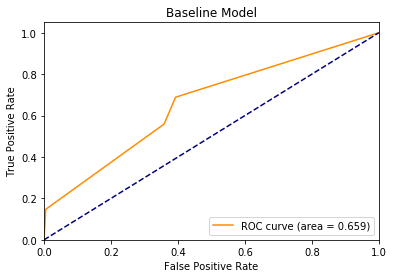

In [66]:
fig, ax = plt.subplots()
plt.plot(fpr_b, tpr_b, color='darkorange', label= f'ROC curve (area = {round(roc_auc_b, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline Model')
plt.legend(loc="lower right")
plt.show()

### Current Top Model - rep and loyalty scores

In [214]:
# TRAIN
X_train_t = sample_train[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors']]

y_train_t = sample_train['vote']

# TEST
X_test_t = sample_test[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors']]

y_test_t = sample_test['vote']

In [215]:
top_model = RandomForestClassifier(n_estimators=1000, max_depth=7, n_jobs=2, random_state=709)
top_model.fit(X_train_t, y_train_t)
y_pred_t = (top_model.predict_proba(X_test_t))[:, 1]

In [216]:
log_loss(y_test_t, y_pred_t)

0.3804464713858777

In [217]:
y_pred_t.min()

0.5640928633165586

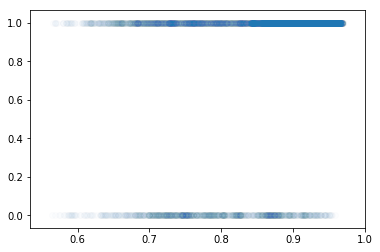

In [218]:
fig, ax = plt.subplots()
ax.scatter(y_pred_t, y_test_t, alpha=0.01)

In [219]:
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t, y_pred_t)

In [220]:
roc_auc_t = roc_auc_score(y_test_t, y_pred_t)
roc_auc_t

0.782268462423954

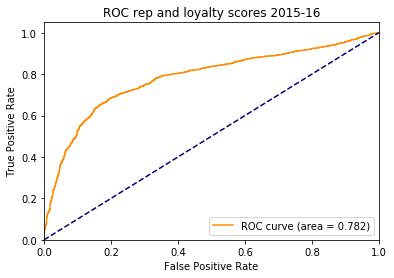

In [221]:
fig, ax = plt.subplots()
plt.plot(fpr_t, tpr_t, color='darkorange', label= f'ROC curve (area = {round(roc_auc_t, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

### Playground

In [ ]:
# TRAIN
X_train = sample_train[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_train = sample_train['vote']

# TEST
X_test = sample_test[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_test = sample_test['vote']

In [ ]:
bills = sample_train['bill_text']
bills_test = sample_test['bill_text']
len(bills)

In [ ]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.85, max_features=8000)

In [ ]:
fitted = tf.fit(bills)

In [ ]:
transformed_train = tf.transform(bills)

In [ ]:
transformed_test = tf.transform(bills_test)

In [ ]:
def tfidf_transformed_to_dataframe(transformed):
    tfidf_cols = transformed.toarray()
    tfidf_names = fitted.get_feature_names()
    tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

    return tfidf_df

In [ ]:
tfidf_train_df = tfidf_transformed_to_dataframe(transformed_train)
X_train = X_train.reset_index().drop('index', axis=1)
X_train = pd.concat([X_train, tfidf_train_df], axis=1)

In [ ]:
tfidf_test_df =  tfidf_transformed_to_dataframe(transformed_test)
X_test = X_test.reset_index().drop('index', axis=1)
X_test = pd.concat([X_test, tfidf_test_df], axis=1)

In [ ]:
X_train.head()

In [ ]:
model = RandomForestClassifier(n_estimators=5000, max_depth=7, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [ ]:
log_loss(y_test, y_pred)

In [ ]:
y_pred.min()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [ ]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [ ]:
X_train.columns

In [ ]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [ ]:
features_importances_sorted

In [ ]:
group = sample_one_year.groupby('vote')

In [ ]:
group.mean()

# Explore bill_text

In [ ]:
nays = sample[sample['vote'] == 0]
yeas = sample[sample['vote'] == 1]

nays.head()
yeas.head()

In [ ]:
# print(nays.loc[2132532, 'bill_text'])

In [ ]:
# print(yeas.loc[2840240, 'bill_text'])

In [ ]:
example_text = yeas.loc[2840240, 'bill_text']

In [ ]:
example_text.replace('\n', ' ')

### TFIDFVectorizer

In [ ]:
bills = sample_one_year['bill_text']

In [ ]:
bills.shape

In [ ]:
wordnet = WordNetLemmatizer()

In [ ]:
def create_bill_tokens(bill):
    bill = bill.replace('\n', ' ') 
    punctuations = set(string.punctuation)
    
    bill = ''.join([char.lower() for char in bill if char not in punctuations])
    bill_tokens = bill.split(' ')
    lemmed_bill = [wordnet.lemmatize(word) for word in bill_tokens] 
    
    return lemmed_bill

In [ ]:
my_stopwords = ['shall', 'chapter', 'provided', 'year', 'person', 'department', 'appropriation', 'provided'
                 'information', 'provide', 'including', 'following', 'section', 'sec', 'year', 'subsection', 
                'agency', 'required',  'use', 'solely', 'ii', 'defined', 'approved', 'does',  'period', 
                'rcw 43', 'persons', 'individual', 'unless', '9a', '28a', 'purpose', '28b',  'washington',  
                'fy',  'iii', 'sec rcw', 'rcw9a', 'rcw',  'apply',  '000general',  '000', 'related',  'sp', 
                'make', 'includes', 'end', 'biennia', 'set', 'terms', 'total', 'level', 'amended', 
                'engrossed', 'substitute', 'legislature', 'enacted', 'passed', 'add', 'additional', 'new', 'board',
                'limited', 'date', 'order', 'plan', 'percent', 'support', 'director', 'child', 'two', 'years', 
                'committee', 'five', 'laws', 'contract', 'prior', 'necessary', 'requirements', 'days', 'based', 
                'made', 'except', 'per', 'number', 'amounts', 'conditions', 'senate', 'house', 'system', 'may',
               'must', 'account', 'one', 'means', 'within', 'county', 'general', 'subject', 'within', 'treatment', 
               'service', 'include', 'used', 'account', 'less', 'part', 'member', 'established', 'law', 'rate', 
                'read', 'follows', 'information', 'program', 'services', 'fund', 'amount', 'agreement', 'payment',
               'commission', 'notice', 'legislature2015', '02', '1st', 'april', 'beginning', 'december', 'january', 
                'february', 'march', 'may', 'june', 'july', 'august', 'sepetmeber', 'november', 'manner', 'plans',
               'need', '060', 'sections', 'either', 'described', 'equivalent', 'recommendations', 'office', 'created',
               'higher', 'hours', 'written', 'address', 'organizations', 'value', 'party', 'full', '030', 'high', 'case',
               'four', '04', 'would', '05', 'day', 'whether', 'pass', '040', 'yeas', 'nays', 'absents', 'yea', 'nay',
                'absents', 'undecided', 'undecideds']

stop_nums = list(set([str(num) for num in range(0, 2025)]))
stopwords_nltk = list(set(stopwords.words('english')))

In [ ]:
stopwords_nltk.extend(my_stopwords)
stopwords_nltk.extend(stop_nums)
stopwords_nltk = set(stopwords_nltk)

In [ ]:
analyzer=create_bill_tokens, 

In [ ]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.9, max_features=5000)

fitted = tf.fit(bills)

transformed = tf.transform(bills)

fitted = tf.fit(bills)

transformed = tf.transform(bills)

vocab = tf.vocabulary_

vocab

tfidf_cols = transformed.toarray()

tfidf_names = fitted.get_feature_names()

tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

tfidf_df.head()

tfidf_df.shape

In [ ]:
fitted = tf.fit(bills)

In [ ]:
transformed = tf.transform(bills)

In [ ]:
vocab = tf.vocabulary_

In [ ]:
vocab

In [ ]:
tfidf_cols = transformed.toarray()

In [ ]:
tfidf_names = fitted.get_feature_names()

In [ ]:
tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

In [ ]:
tfidf_df.head()

In [ ]:
tfidf_df.shape

In [ ]:
# cv = CountVectorizer(stop_words=stopwords_nltk, analyzer='word', ngram_range=(1, 4), max_df=0.9, max_features = 200000)
# cv_fit = cv.fit_transform(bills)
# word_counts = pd.DataFrame(cv_fit.toarray(), columns= cv.get_feature_names())
# word_counts = word_counts.sum(axis=0)
# words_sorted = word_counts.sort_values(ascending=False)
# words_sorted_only = words_sorted.index
# for word in words_sorted_only [100:150]:
#     print(word)

In [ ]:
features_importances_sorted[0:50]